# Image Augmentation Model Search

# TODO

Exploring image augmentation via RandAugment.

In [1]:
!pip install imgaug -qq

In [2]:
import numpy as np
import pandas as pd
import imgaug as ia
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras
from imgaug import augmenters as iaa
from keras.applications import imagenet_utils

Some parameters:

In [3]:
AUTO = tf.data.AUTOTUNE

DATASET_SIZE = 9367
TRAIN_SIZE = 4447
VALID_SIZE = 1112

IMAGE_SIZE = 224
BATCH_SIZE = 16
WORKERS = 4
EPOCHS = 10

BASE_PATH='../data'

classes = [
    'cup', 
    'fork', 
    'glass', 
    'knife', 
    'plate', 
    'spoon'
]

Loading training data and splitting into train and validation

In [4]:
df_train_full = pd.read_csv(BASE_PATH + '/train.csv', dtype={'Id': str})
df_train_full['filename'] = BASE_PATH + '/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,../data/images/0560.jpg
1,4675,cup,../data/images/4675.jpg
2,0875,glass,../data/images/0875.jpg
3,4436,spoon,../data/images/4436.jpg
4,8265,plate,../data/images/8265.jpg


In [5]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

### Functions for loading data:

In [6]:
# These models don't have the imagenet preprocessing built in so I have to apply this
def preprocess_input(x, data_format=None):
    return imagenet_utils.preprocess_input(
        x, data_format=data_format, mode="tf"
    )

In [7]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     dtype="float16"
# )
# val_datagen= tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     dtype="float16"
# )

# train_gen = train_datagen.flow_from_dataframe(
#     df_train,
#     x_col='filename',
#     y_col='label',
#     target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
# )

# val_gen = val_datagen.flow_from_dataframe(
#     df_val,
#     x_col='filename',
#     y_col='label',
#     target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
# )

Making Dataset:

In [8]:
# train_dataset = tf.data.Dataset.from_generator(
#     lambda: train_data ,  # Our generator 
#     output_signature = tf.TensorSpec(shape=[[BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3] , [BATCH_SIZE , ]], dtype=tf.float16)
#     # output_types = (tf.float16 , tf.float16) , # How we're expecting our output dtype
#     # output_shapes = ([BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3] , [BATCH_SIZE , ]) # How we're expecting our output shape
# )
# train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(TRAIN_SIZE))

# valid_dataset = tf.data.Dataset.from_generator(
#     lambda: val_data , 
#     output_signature = tf.TensorSpec(shape=[[BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3] , [BATCH_SIZE , ]], dtype=tf.float16)
#     # output_types = (tf.float16 , tf.float16), 
#     # output_shapes = ([BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3] , [BATCH_SIZE , ])
# )
# valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(VALID_SIZE))

## RandAugment:

(from Keras tutorials https://keras.io/examples/vision/randaugment/)

In [9]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    # images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [10]:
def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], 'nearest')
    return image

In [ ]:
train_processed = (
    train_dataset
    .map(
        lambda x, y: (preprocess_input(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [11]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((df_train.filename.values, df_train.label.values))
    .map(
        lambda x, y: (process_path(x), y),
        num_parallel_calls=AUTO,
    )
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((df_val.filename.values, df_val.label.values))
    .map(
        lambda x, y: (process_path(x), y),
        num_parallel_calls=AUTO,
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

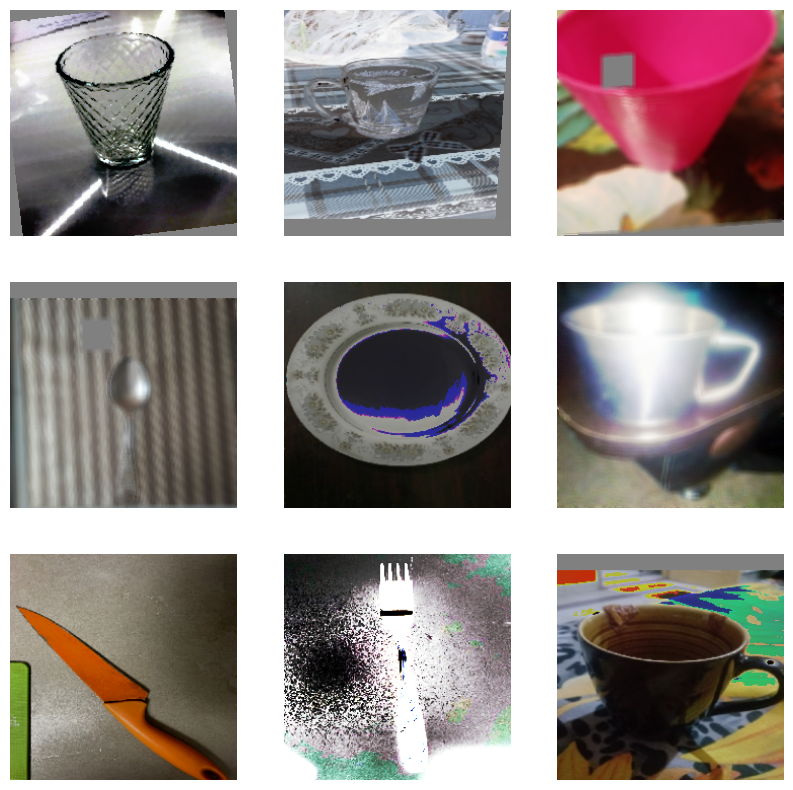

In [12]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [13]:
sample_images.shape

TensorShape([16, 224, 224, 3])

## Build model:

In [14]:
from keras_cv_attention_models import beit

In [15]:
def build_model():
    # Getting model
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    base_model = beit.BeitLargePatch16( #BeitBasePatch16(
        pretrained='imagenet21k-ft1k',  #weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        num_classes=len(classes)
    )
    base_model.trainable = False

    # Removing the old classification head for my own
    base_model = tf.keras.Model(inputs=base_model.layers[1].input, outputs= base_model.layers[-3].output)

    # Adding classification head
    model = tf.keras.Sequential([
        inputs,
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(12, 'gelu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(6, 'softmax')
    ],
    name = f'beit_large_patch_16_{IMAGE_SIZE}')

    # Getting optimizer
    learning_rate = 0.01
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compiling                              
    model.compile(
        optimizer = optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Testing RandAug:

In [16]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 1e-4,
    patience = 5,
    mode = 'max',
    restore_best_weights = True,
    verbose = 1
)

callbacks = [earlystopping]

In [17]:
model = build_model()

>>>> Load pretrained from: C:\Users\andre\.keras\models\beit_large_patch16_224_imagenet21k-ft1k.h5


In [18]:
model.summary()

Model: "beit_large_patch_16_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1024)              303403520 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 12)                12300     
                                                                 
 batch_normalization_1 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)     

In [19]:
history = model.fit(
    x = train_ds_rand,
    validation_data=val_ds,
    # batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    workers=WORKERS,
    callbacks=callbacks
)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\andre\anaconda3\envs\keras-attention-models\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 6) are incompatible


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()